In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# from desc import set_device
# set_device("gpu")

In [2]:
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance
)
from desc.basis import ZernikePolynomial, FourierZernikeBasis,FourierZernike_to_FourierZernike_no_N_modes,get_basis_poincare, DoubleFourierSeries
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_1d,plot_2d,plot_3d,plot_comparison, plot_section, plot_fsa, plot_surfaces
from desc.optimize import Optimizer
from desc.perturbations import *
import numpy as np
from desc.geometry import FourierRZToroidalSurface, ZernikeRZToroidalSection, PoincareSurface
%matplotlib inline
from desc.utils import copy_coeffs, print_modes_coefs
import matplotlib.pyplot as plt
from desc.examples import get
from desc.objectives.getters import get_fixed_boundary_constraints, get_fixed_xsection_constraints, maybe_add_self_consistency
from desc.grid import LinearGrid
import plotly.graph_objects as go

DESC version 0.10.4+1020.g0e6f84d88,using JAX backend, jax version=0.4.25, jaxlib version=0.4.25, dtype=float64
Using device: CPU, with 11.20 GB available memory


In [3]:
def get_poin_GS(eq):
    eq_poin = eq.set_poincare_equilibrium()
    eq_poin.change_resolution(eq.L,eq.M,eq.N) 
    surf=eq_poin.get_surface_at(rho=1)
    
    eq_GS = Equilibrium(
        surface=surf,
        pressure=eq_poin.pressure,
        iota=eq_poin.iota,
        Psi=eq_poin.Psi, # flux (in Webers) within the last closed flux surface
        NFP=eq_poin.NFP, # number of field periods
        L=eq_poin.L, # radial spectral resolution
        M=eq_poin.M, # poloidal spectral resolution
        N=0, # toroidal spectral resolution 
        L_grid=eq_poin.L_grid, # real space radial resolution, slightly oversampled
        M_grid=eq_poin.M_grid, # real space poloidal resolution, slightly oversampled
        N_grid=eq_poin.N_grid, # real space toroidal resolution
        sym=True, # explicitly enforce stellarator symmetry
        spectral_indexing=eq_poin._spectral_indexing,  
    )
    return eq_GS

def get_perturbed_GS_Poincare(eq, eq_GS, eq_poin, step, numstep):
    surface_Poincare = eq_poin.get_surface_at(zeta=0)
    surface_GS = eq_GS.get_surface_at(zeta=0)
    
    Rb_lmn = surface_GS.R_lmn + (surface_Poincare.R_lmn - surface_GS.R_lmn)*step/numstep
    Zb_lmn = surface_GS.Z_lmn + (surface_Poincare.Z_lmn - surface_GS.Z_lmn)*step/numstep
    
    Rb_basis = surface_GS.R_basis
    Zb_basis = surface_GS.Z_basis
    
    L_GS_lmn, L_GS_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_GS.L_lmn, eq_GS.L_basis)
    L_GS_lmn, L_GS_basis = get_basis_poincare(L_GS_lmn, L_GS_basis)
    
    L_Poin_lmn, L_Poin_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_poin.L_lmn, eq_poin.L_basis)
    L_Poin_lmn, L_Poin_basis = get_basis_poincare(L_Poin_lmn, L_Poin_basis)

    Lb_lmn = L_GS_lmn + (L_Poin_lmn - L_GS_lmn)*step/numstep

    surf = ZernikeRZToroidalSection(
        R_lmn=Rb_lmn,
        modes_R=Rb_basis.modes[:, :2].astype(int),
        Z_lmn=Zb_lmn,
        modes_Z=Zb_basis.modes[:, :2].astype(int),
        spectral_indexing=eq_poin._spectral_indexing,
    )
    
    surface = PoincareSurface(surface=surf, L_lmn=Lb_lmn, modes_L=L_GS_basis.modes)
    
    eq.surface = surface
    return eq

def get_perturbed_surface(eq, eq_GS, eq_poin, step, numstep):
    surface_Poincare = eq_poin.get_surface_at(zeta=0)
    surface_GS = eq_GS.get_surface_at(zeta=0)
    
    Rb_lmn = surface_GS.R_lmn + (surface_Poincare.R_lmn - surface_GS.R_lmn)*step/numstep
    Zb_lmn = surface_GS.Z_lmn + (surface_Poincare.Z_lmn - surface_GS.Z_lmn)*step/numstep
    
    Rb_basis = surface_GS.R_basis
    Zb_basis = surface_GS.Z_basis
    
    L_GS_lmn, L_GS_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_GS.L_lmn, eq_GS.L_basis)
    L_GS_lmn, L_GS_basis = get_basis_poincare(L_GS_lmn, L_GS_basis)
    
    L_Poin_lmn, L_Poin_basis = FourierZernike_to_FourierZernike_no_N_modes(eq_poin.L_lmn, eq_poin.L_basis)
    L_Poin_lmn, L_Poin_basis = get_basis_poincare(L_Poin_lmn, L_Poin_basis)

    Lb_lmn = L_GS_lmn + (L_Poin_lmn - L_GS_lmn)*step/numstep

    surf = ZernikeRZToroidalSection(
        R_lmn=Rb_lmn,
        modes_R=Rb_basis.modes[:, :2].astype(int),
        Z_lmn=Zb_lmn,
        modes_Z=Zb_basis.modes[:, :2].astype(int),
        spectral_indexing=eq_poin._spectral_indexing,
    )
    
    surface = PoincareSurface(surface=surf, L_lmn=Lb_lmn, modes_L=L_Poin_basis.modes)

    return surface

def get_perturbed_init_eq(eq, eq_GS, eq_poin, step, numstep):
    surface_Poincare = eq_poin.get_poincare_surface_at(zeta=0)
    surface_GS = eq_GS.get_poincare_surface_at(zeta=0)
    
    surface_Poincare.change_resolution(L=eq_poin.L, M=eq_poin.M)
    surface_GS.change_resolution(L=eq_poin.L, M=eq_poin.M)
    
    Rb_lmn = surface_GS.R_lmn + (surface_Poincare.R_lmn - surface_GS.R_lmn)*step/numstep
    Zb_lmn = surface_GS.Z_lmn + (surface_Poincare.Z_lmn - surface_GS.Z_lmn)*step/numstep
    Lb_lmn = surface_GS.L_lmn + (surface_Poincare.L_lmn - surface_GS.L_lmn)*step/numstep
    
    Rb_basis = surface_GS.R_basis
    Zb_basis = surface_GS.Z_basis
    Lb_basis = surface_GS.L_basis
    
    surface = PoincareSurface(R_lmn=Rb_lmn,
                              Z_lmn=Zb_lmn,
                              L_lmn=Lb_lmn, 
                              modes_R=Rb_basis.modes,
                              modes_Z=Zb_basis.modes,
                              modes_L=Lb_basis.modes,
                             )
    eq_new = Equilibrium(
        surface=surface,
        pressure=eq_poin.pressure,
        iota=eq_poin.iota,
        Psi=eq_poin.Psi, # flux (in Webers) within the last closed flux surface
        NFP=eq_poin.NFP, # number of field periods
        L=eq_poin.L, # radial spectral resolution
        M=eq_poin.M, # poloidal spectral resolution
        N=0, # toroidal spectral resolution 
        L_grid=eq_poin.L_grid, # real space radial resolution, slightly oversampled
        M_grid=eq_poin.M_grid, # real space poloidal resolution, slightly oversampled
        N_grid=eq_poin.N_grid, # real space toroidal resolution
        sym=True, # explicitly enforce stellarator symmetry
        spectral_indexing=eq_poin._spectral_indexing,  
    )
    return eq_new

### Get Heliotron and Construct Poincare, Grad-Shafranov Initial Guesses

/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of field periods for grid 1 and basis 19.
  warnings.warn(
/home/yigit/Codes/DESC/desc/transform.py:69: UserWarning: Unequal number of 

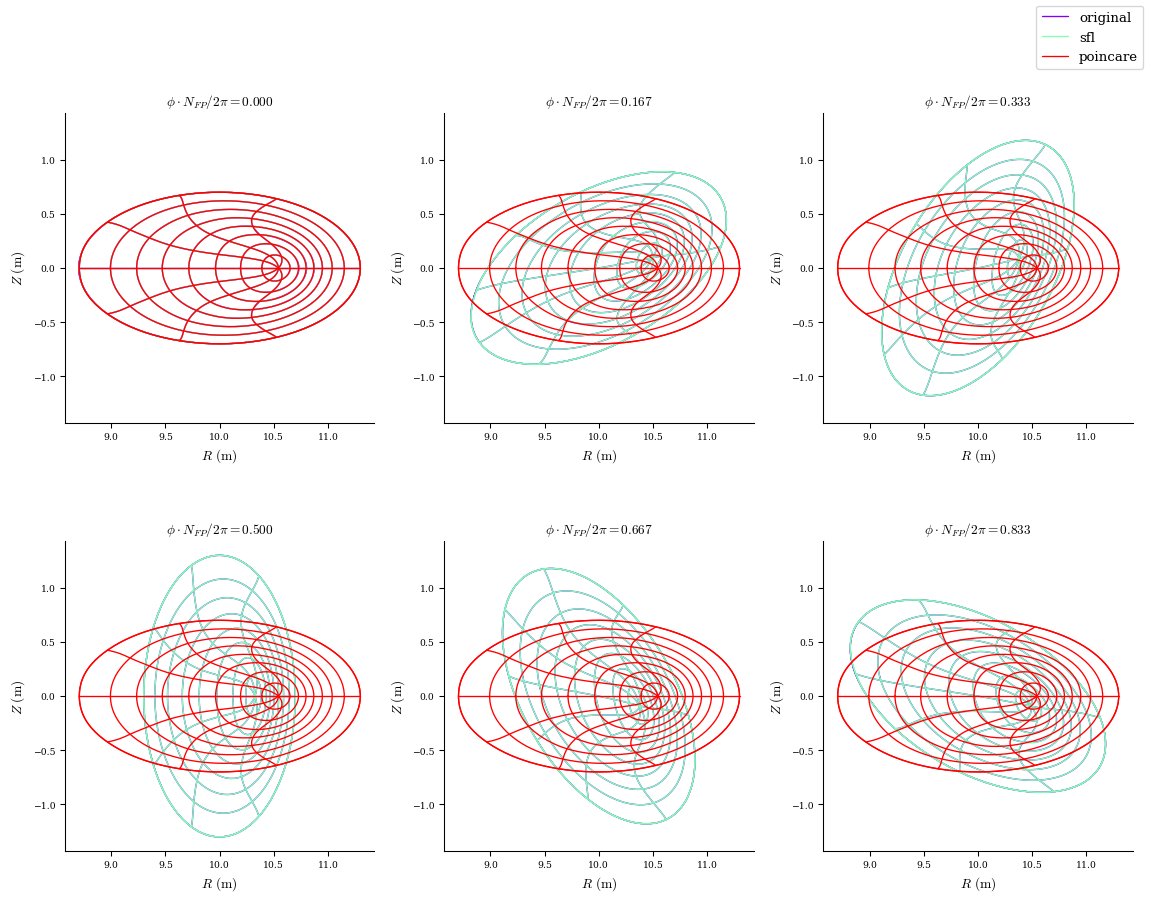

In [9]:
eq = get("HELIOTRON")
print("constructing Poincare ...")
eq_poin = eq.set_poincare_equilibrium()
print("constructing GS ...")
eq_GS = eq_poin.copy()
eq_GS.surface = eq_poin.get_surface_at(rho=1)

In [8]:
print_modes_coefs(eq_sfl, "L")

Printing 585 results for L coordinate of Equilibrium
-------------------------------------
l = 0    m = 0    n = -3   L_lmn =   0.00000000
l = 1    m = 1    n = -3   L_lmn =   0.00000000
l = 2    m = 0    n = -3   L_lmn =   0.00000000
l = 2    m = 2    n = -3   L_lmn =   0.00000000
l = 3    m = 1    n = -3   L_lmn =   0.00000000
l = 3    m = 3    n = -3   L_lmn =   0.00000000
l = 4    m = 0    n = -3   L_lmn =   0.00000000
l = 4    m = 2    n = -3   L_lmn =   0.00000000
l = 4    m = 4    n = -3   L_lmn =   0.00000000
l = 5    m = 1    n = -3   L_lmn =   0.00000000
l = 5    m = 3    n = -3   L_lmn =   0.00000000
l = 5    m = 5    n = -3   L_lmn =   0.00000000
l = 6    m = 0    n = -3   L_lmn =   0.00000000
l = 6    m = 2    n = -3   L_lmn =   0.00000000
l = 6    m = 4    n = -3   L_lmn =   0.00000000
l = 6    m = 6    n = -3   L_lmn =   0.00000000
l = 7    m = 1    n = -3   L_lmn =   0.00000000
l = 7    m = 3    n = -3   L_lmn =   0.00000000
l = 7    m = 5    n = -3   L_lmn =   0.000000

### Solve Grad-Shafranov

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 2.51 sec
Timer: Objective build = 5.41 sec
Timer: Linear constraint projection build = 5.45 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 728 ms
Timer: Jacobian compilation time = 4.50 sec
Timer: Total compilation time = 5.23 sec
Number of parameters: 222
Number of objectives: 380
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.073e-01                                    1.224e+01   
       1              5          7.190e-02      3.538e-02      9.386e-02      5.819e+01   
       2              6          2.074e-02      5.116e-02      6.034e-02      5.127e+00   
       3              7          5.919e-03      1.482e-02      1.030e-01      2.551e+01   
       4              8          6.414e-04      5.278e-03      1.197e-01      5.353e

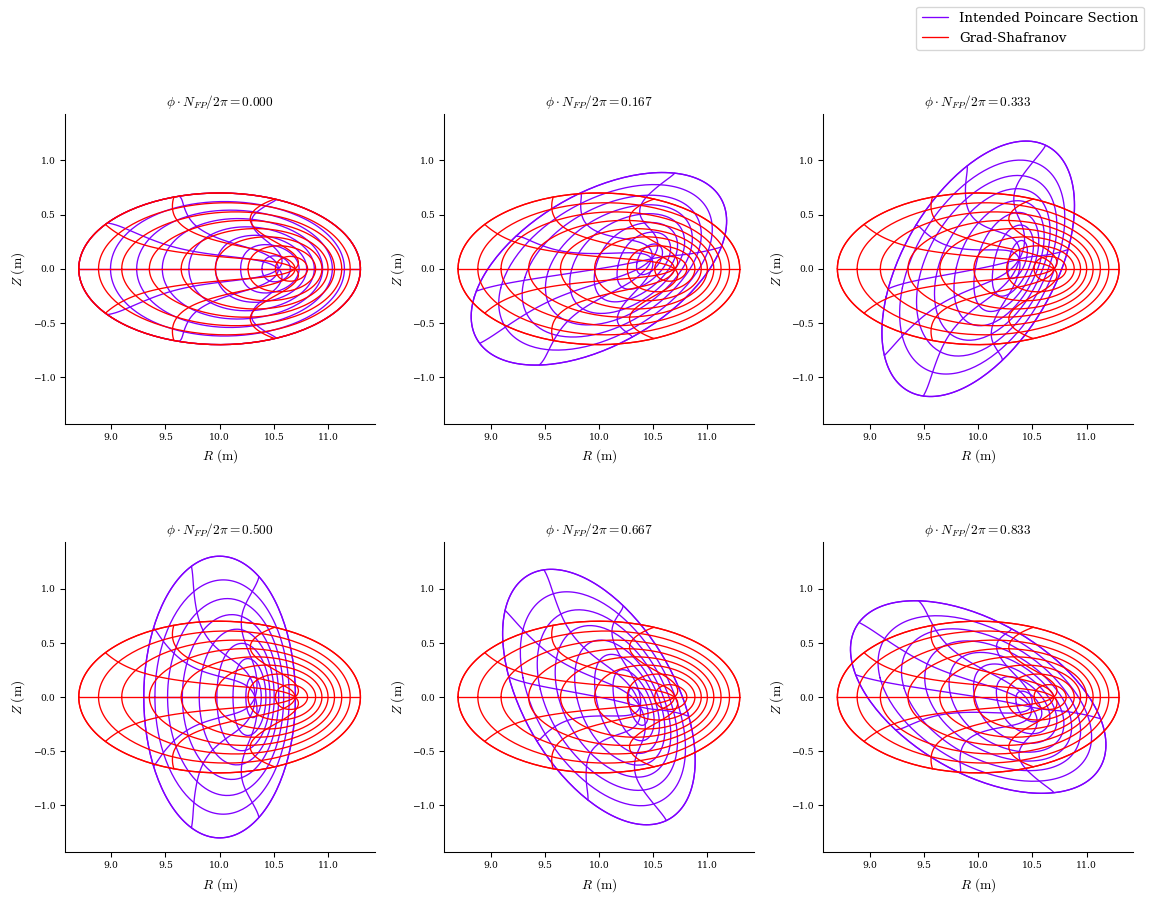

In [5]:
maxiter_GS = 100
eq_GS.change_resolution(eq.L,eq.M,0, N_grid=0)
constraints = get_fixed_boundary_constraints(eq=eq_GS)
objective = ObjectiveFunction(ForceBalance(eq_GS))
eq_GS.solve(verbose=3, objective=objective, constraints=constraints, maxiter=maxiter_GS, ftol=0, xtol=0, gtol=0)
plot_comparison(eqs=[eq,eq_GS],labels=['Intended Poincare Section','Grad-Shafranov']);

### Solve Poincare BC using Single Perturbation

Building objective: force
Precomputing transforms
Perturbing 
Factorizing linear constraints
Computing df
Factoring df
Computing d^2f
||dx||/||x|| =  9.998e-03


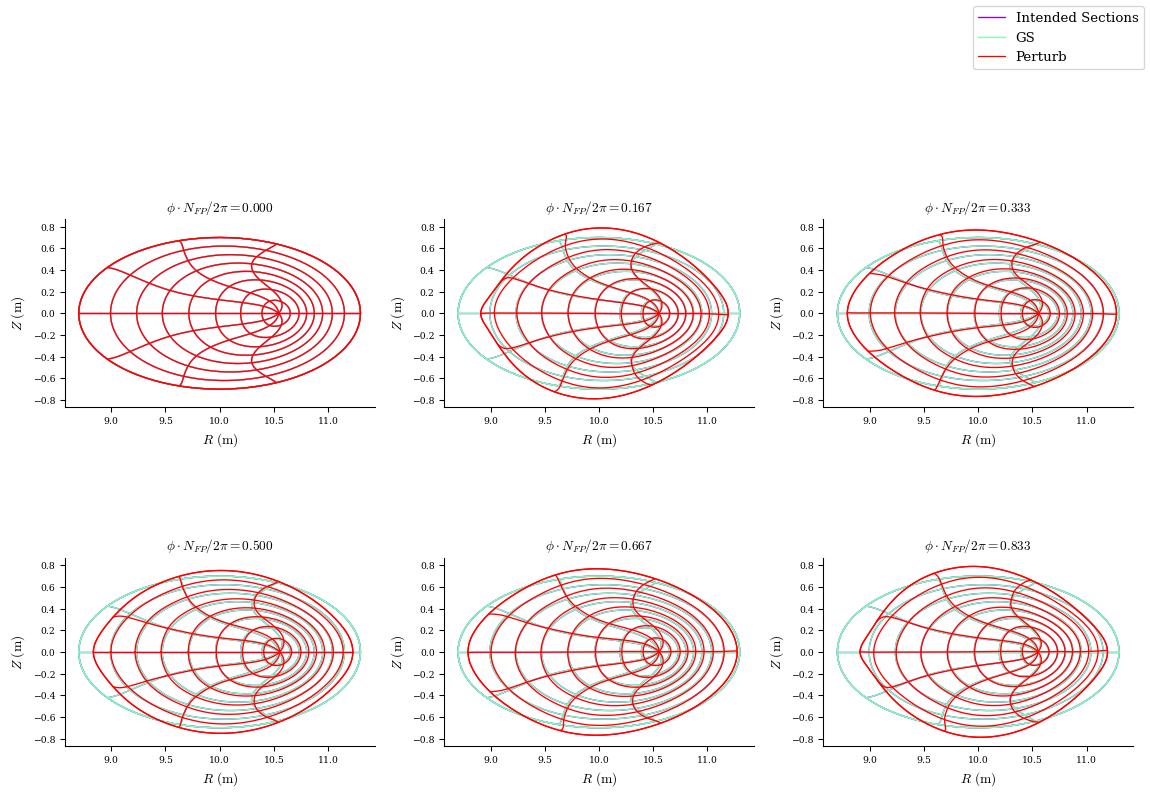

In [5]:
eq_GS.change_resolution(eq.L,eq.M,eq.N) 
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb = eq_GS_poincare.copy()
eq_perturb.change_resolution(eq.L,eq.M,3, N_grid=6)

surf1 = eq_perturb.xsection
surf2 = eq_poin.xsection

things1 = {"surface_poincare": surf1}
things2 = {"surface_poincare": surf2}

deltas = get_deltas(things1, things2)
constraints = get_fixed_xsection_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))

eq_perturb.perturb(objective=objective, constraints=constraints, deltas=deltas, tr_ratio=0.01)

plot_comparison(eqs=[eq_poin,eq_GS,eq_perturb],labels=['Intended Sections','GS','Perturb']);

Solving after perturbation...
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 167 ms
Timer: Objective build = 430 ms
Timer: Linear constraint projection build = 2.08 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.39 sec
Timer: Jacobian compilation time = 6.38 sec
Timer: Total compilation time = 7.77 sec
Number of parameters: 1696
Number of objectives: 4940
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.804e-04                                    2.659e+00   
       1              5          4.566e-05      1.348e-04      1.617e-02      7.054e-01   
       2              6          4.525e-05      4.089e-07      2.381e-02      1.041e+00   
       3              7          1.179e-05      3.346e-05      9.082e-03      2.311e-01   
       4              8          1.108e-05      7.067e

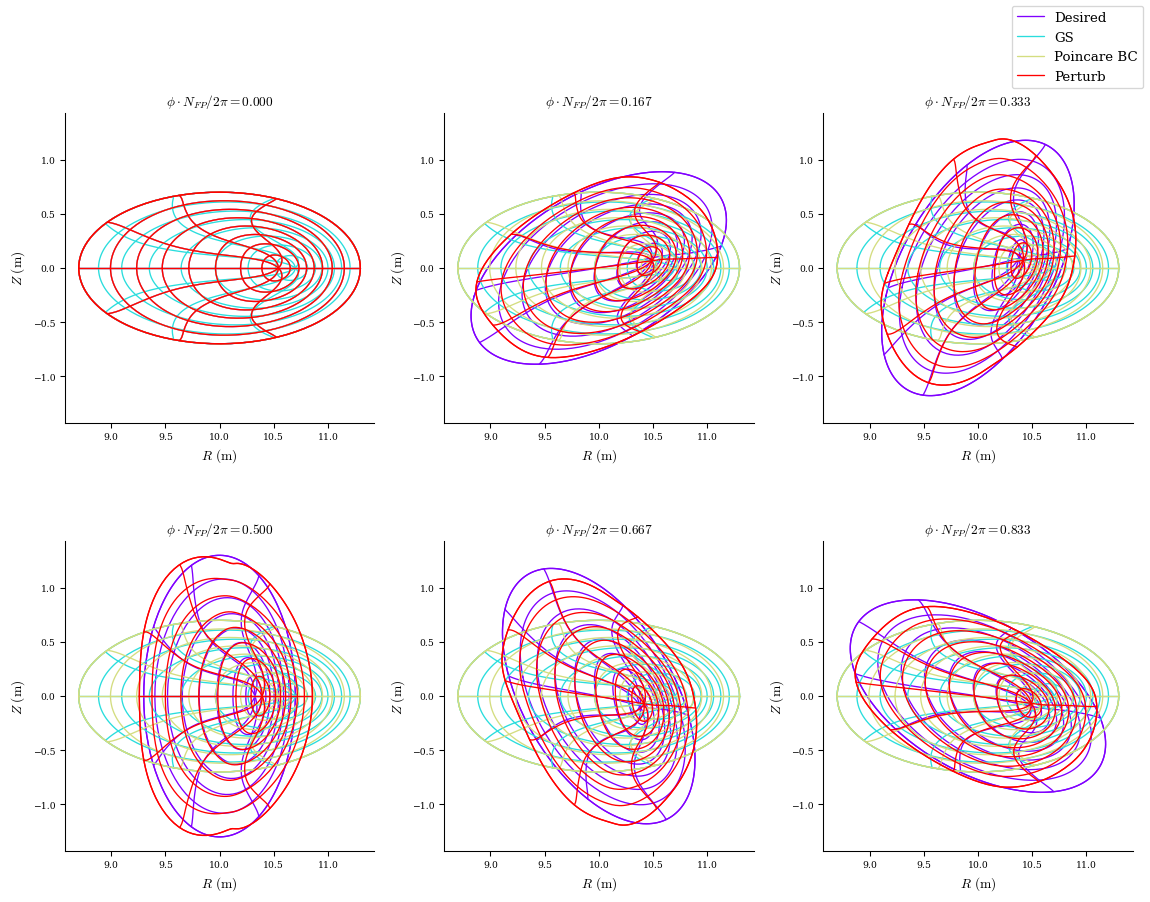

In [15]:
print("Solving after perturbation...")
constraints = get_fixed_xsection_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))

eq_perturb.solve(verbose=3, objective=objective, constraints=constraints, maxiter=10, ftol=0, xtol=0, gtol=0)

plot_comparison(eqs=[eq,eq_GS,eq_poin,eq_perturb],labels=['Desired','GS','Poincare BC', 'Perturb']);

In [ ]:
# plot_comparison(eqs=[eq,eq_perturb],labels=['Desired','Perturb']);
plot_section(eq_perturb,"|F|", log=True);
plot_section(eq,"|F|", log=True);

### Solve Poincare BC using multiple Perturbations

In [ ]:
NumStep = 2
maxiter = 1

eq_GS.change_resolution(eq.L,eq.M,eq.N) 
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb_step = eq_GS_poincare.copy()
eq_perturb_step.change_resolution(eq.L,eq.M,eq.N)

for step in range(1,NumStep+1):
    eq_prev = eq_perturb_step.copy()

    eq_perturb_step = get_perturbed_init_eq(
        eq=eq_perturb_step,eq_GS=eq_GS,eq_poin=eq_poin,step=step,numstep=NumStep
    )

    plot_comparison(eqs=[eq,eq_prev,eq_perturb_step],labels=['LCFS',f'Step: {step-1}',f'Step: {step}']);

In [ ]:
NumStep = 2
maxiter = 20

eq_GS.change_resolution(eq.L,eq.M,eq.N) 
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb_step = eq_GS_poincare.copy()
eq_perturb_step.change_resolution(eq.L,eq.M,eq.N)

for step in range(1,NumStep+1):
    eq_prev = eq_perturb_step.copy()

    surf1 = eq_perturb_step.surface
    surf2 = get_perturbed_init_eq(
        eq=eq_perturb_step,eq_GS=eq_GS_poincare,eq_poin=eq_poin,step=step,numstep=NumStep
    ).surface
    
    print(surf1.R_basis.num_modes)
    print(surf2.R_basis.num_modes)

    # print_modes_coefs(surf1, "R")
    # print_modes_coefs(surf2, "R")

    things1 = {"surface_poincare": surf1}
    things2 = {"surface_poincare": surf2}

    deltas = get_deltas(things1, things2)
    constraints = get_fixed_boundary_constraints(eq=eq_perturb_step)
    objective = ObjectiveFunction(ForceBalance(eq_perturb_step))

    eq_perturb_step.perturb(objective=objective, constraints=constraints, deltas=deltas, tr_ratio=0.02)
    eq_perturb_step.solve(verbose=3, objective=objective, constraints=constraints, maxiter=maxiter, ftol=0, xtol=0, gtol=0)
    
    plot_comparison(eqs=[eq,eq_prev,eq_perturb_step],labels=['LCFS',f'Step: {step-1}',f'Step: {step}']);

### Solve Poincare BC using lazy Perturbation

In [ ]:
NumStep = 2
maxiter = 1
eq_step = eq_GS.copy()

for step in range(1,NumStep+1):
    eq_prev = eq_step.copy()
    eq_step = get_perturbed_GS_Poincare(eq=eq_step,eq_GS=eq_GS,eq_poin=eq_poin,step=step,numstep=NumStep)
    
    constraints = get_fixed_boundary_constraints(eq=eq_step)
    objective = ObjectiveFunction(ForceBalance(eq_step))

    eq_step.solve(verbose=3, objective=objective, constraints=constraints, maxiter=maxiter, ftol=0, xtol=0, gtol=0)
    
    plot_comparison(eqs=[eq,eq_prev,eq_step],labels=['LCFS',f'GS-Continuation step: {step-1}',f'GS-Continuation step: {step}']);

### Solve Poincare BC straight

In [ ]:
from tests.utils import area_difference, compute_coords

print("Creating equilibrium...")
eq = get("HELIOTRON")
eq_poin = eq.set_poincare_equilibrium()
eq_GS = eq_poin.copy()
eq_GS.surface = eq_poin.get_surface_at(rho=1)
eq_GS.change_resolution(eq.L,eq.M,0, N_grid=0)

print("\nSolving Grad Shafranov...")
constraints = get_fixed_boundary_constraints(eq=eq_GS)
objective = ObjectiveFunction(ForceBalance(eq_GS))
eq_GS.solve(verbose=3, objective=objective, constraints=constraints, maxiter=100, ftol=0, xtol=0, gtol=0)

print("\nPerturbing GS...")
eq_GS.change_resolution(eq.L,eq.M,eq.N, N_grid=eq.N_grid) 
eq_GS_poincare = eq_GS.set_poincare_equilibrium()
eq_perturb = eq_GS_poincare.copy()
eq_perturb.change_resolution(eq.L,eq.M,3)

surf1 = eq_perturb.surface
surf2 = eq_poin.surface

things1 = {"surface_poincare": surf1}
things2 = {"surface_poincare": surf2}

deltas = get_deltas(things1, things2)
constraints = get_fixed_boundary_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))
eq_perturb.perturb(objective=objective, constraints=constraints, deltas=deltas, tr_ratio=0.02)

print("\nSolving last time...")
constraints = get_fixed_boundary_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))
eq_perturb.solve(verbose=3, objective=objective, constraints=constraints, maxiter=10, ftol=0, xtol=0, gtol=0)

plot_comparison(eqs=[eq,eq_perturb],labels=['LCFS','Poincare BC']);   

In [ ]:
print("\nSolving last time...")
constraints = get_fixed_boundary_constraints(eq=eq_perturb)
objective = ObjectiveFunction(ForceBalance(eq_perturb))
eq_perturb.solve(verbose=3, objective=objective, constraints=constraints, maxiter=10, ftol=0, xtol=0, gtol=0)

plot_comparison(eqs=[eq,eq_perturb],labels=['LCFS','Poincare BC']);  

In [ ]:
Rr1, Zr1, Rv1, Zv1 = compute_coords(eq, Nz=6)
Rr2, Zr2, Rv2, Zv2 = compute_coords(eq_perturb, Nz=6)
rho_err, theta_err = area_difference(Rr1, Rr2, Zr1, Zr2, Rv1, Rv2, Zv1, Zv2)
np.testing.assert_allclose(rho_err, 0, atol=1e-2)
np.testing.assert_allclose(theta_err, 0, atol=1e-2)